# Using DECam Images to Subtract DP1 Images

**Description:** This notebook demonstrates how to use SLIDE to perform image subtraction on LSST data using DECam templates

**author:** Yize Dong

**email:** yize.dong@cfa.harvard.edu



## load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from slide_lsst.subtraction import lsst_decam_data_load, perform_image_subtraction, load_usesr_decam
from slide_lsst.lsst_utils import query_lsst_visits, astropy_world_to_pixel, forced_phot
from lsst.daf.butler import Butler
from astropy.visualization import PercentileInterval, ImageNormalize

In [2]:
butler = Butler("dp1", collections="LSSTComCam/DP1")

## query images

Find images that are within the timespan and contain the source we are interested. We will only reduce one image as an example

In [3]:
ra = 58.335054 
dec = -48.750303
band = 'g'
time1 = '2024-11-30'
time2 = '2024-12-10'
data_query = query_lsst_visits(butler=butler, ra=ra, dec=dec, band=band, time1=time1, time2=time2)

In [4]:
data_query[0]

DatasetRef(DatasetType('visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCam', detector: 2, visit: 2024120800422, band: 'g', day_obs: 20241208, physical_filter: 'g_01'}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=7fe8d556-dab5-4876-ae3c-e8575e59426e)

In [5]:
visit_image = butler.get(data_query[0])

## Prepare for the difference imaging step

This step will download the templates from DES-DR2, generate PSFs for the images, and align the template image with the science image.

- Set **`refine_wcs_sci=True`** to refine the WCS of the DP1 images. This may improve the subtraction, especially when the image quality is poor.
- Set **`make_sci_psf=True`** if you want to regenerate the science PSF.
- To perform subtraction on a cutout (as in this example), set **`cutout=True`** and specify the cutout size in pixels using **`cutout_size=1000`**.
- To run subtraction on the full CCD image, set **`cutout=False`**.
- To save the science and template images, set **`save_intermediate=True`**. The images will be saved to the specified **`workdir`**.
- To use templates from DeCaLS instead of DES, set **`download_DES_temp=False`** and **`download_DECaLS_temp=True`**.

INFO: Query finished. [astroquery.utils.tap.core]


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

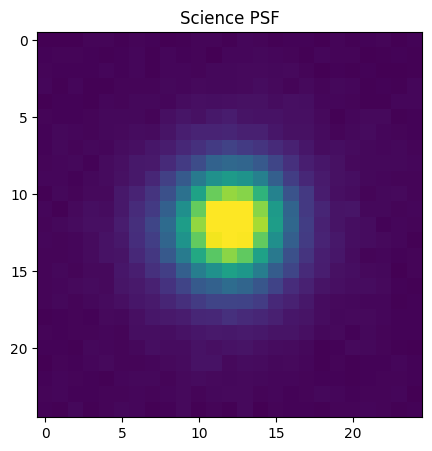

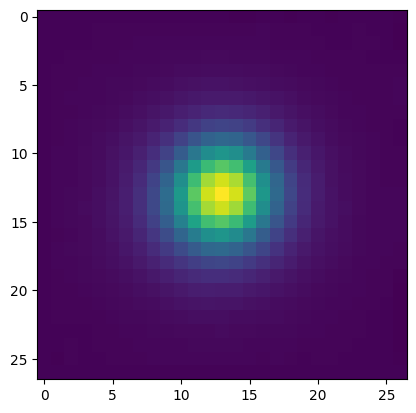

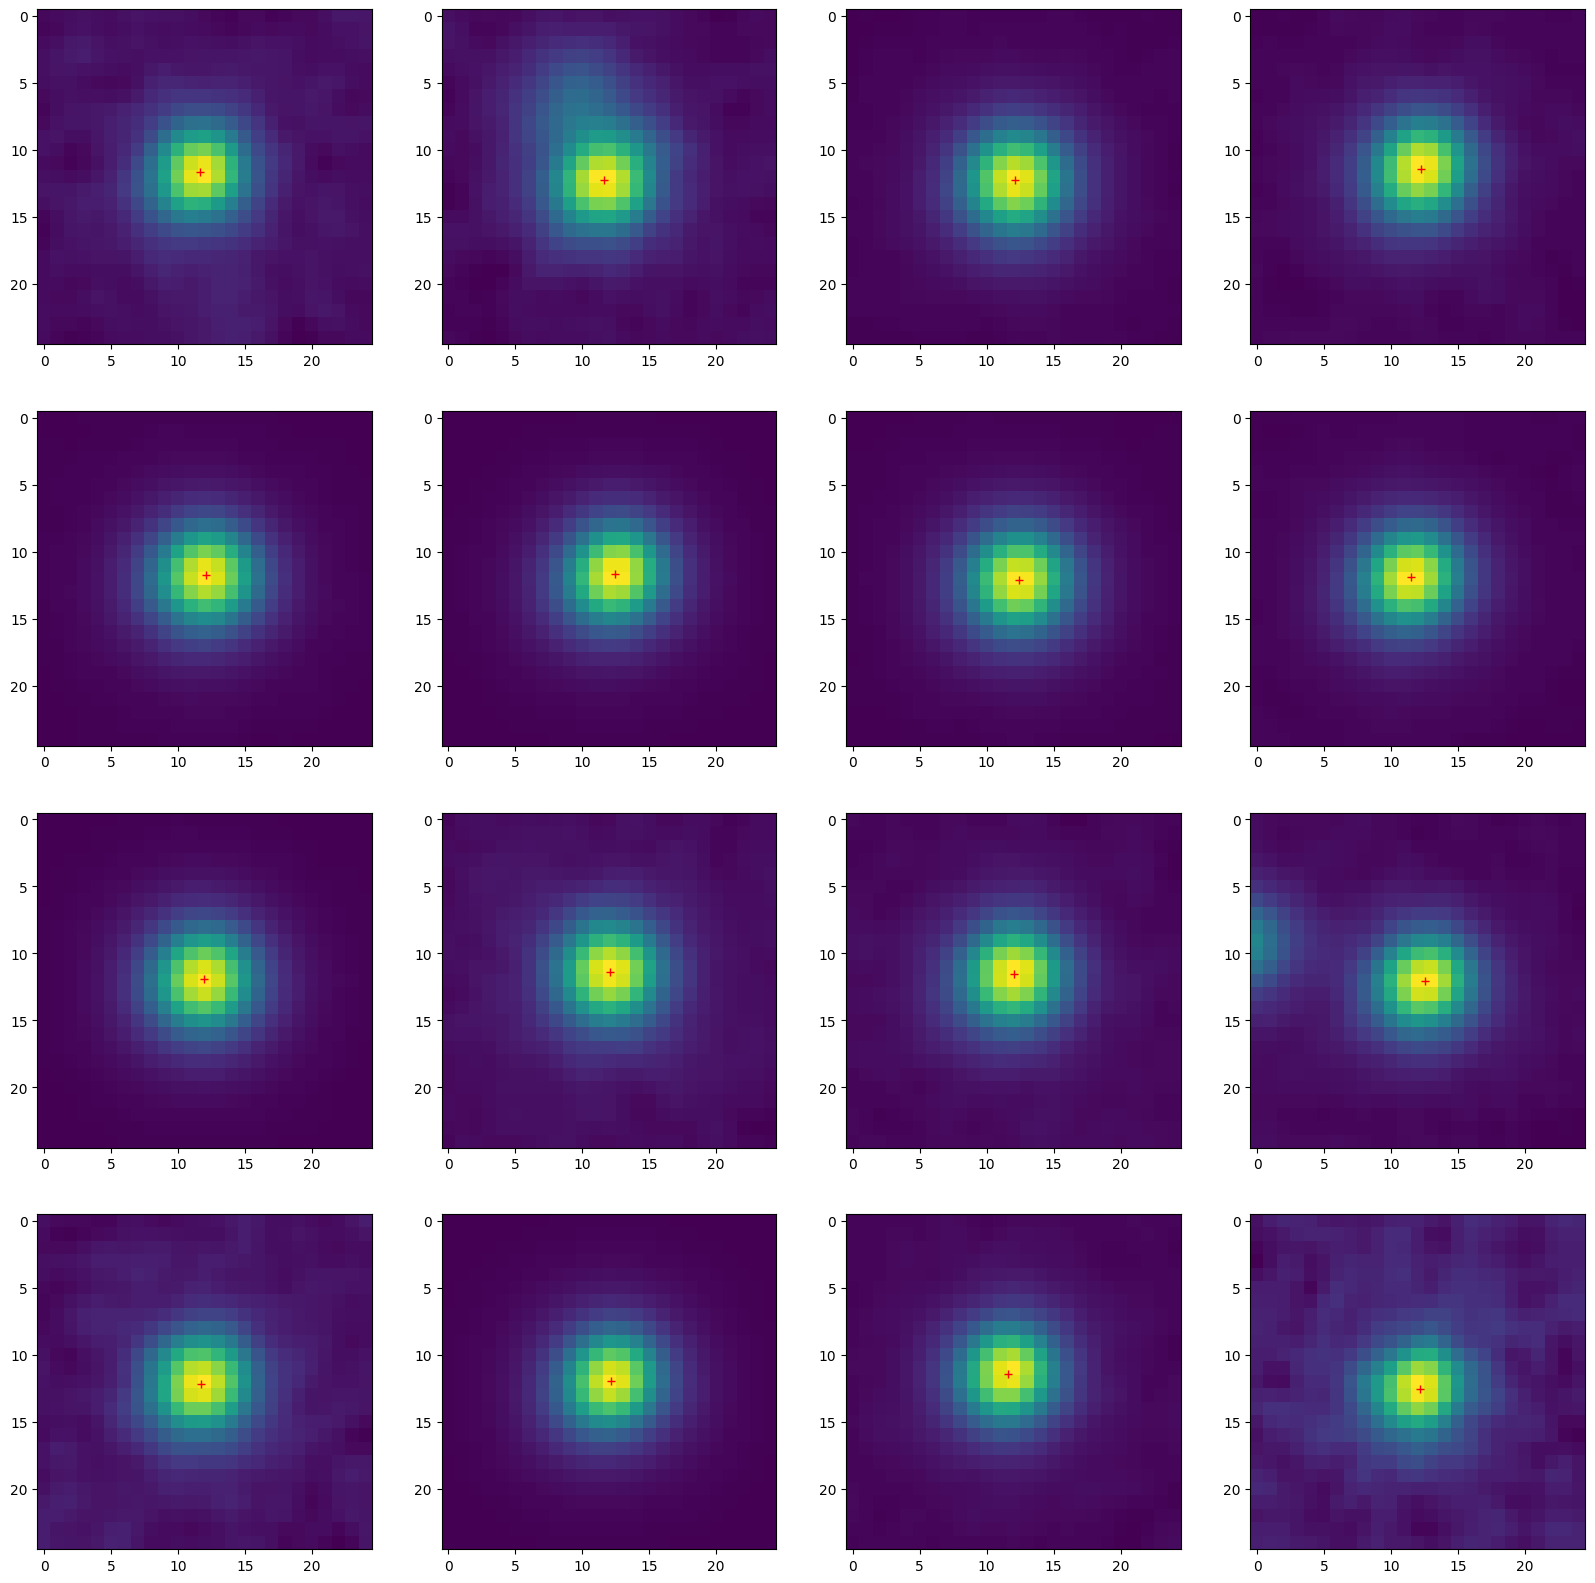

In [6]:
scidata, refdata, sci_psf, ref_psf = lsst_decam_data_load(visit_image, ra = ra, dec = dec, download_DES_temp=True, download_DECaLS_temp=False,
                                                          show=True, 
                                                          refine_wcs_sci=False, make_sci_psf=False,
                                                          cutout=True, cutout_size=1500, reference_catalog='gaia', workdir='./',
                                                                          save_intermediate=False)

## Image subtraction

This step performs image subtraction and returns the aligned template, the final difference image, and the PSF to be used for the photometry stage.

Note: This process can take some time depending on the image size.

- To save the difference images, set **`save_diff=True`**. The images will be saved to the specified **`workdir`**.
- The server on RSP has a memory limit of 16 GB. To protect the server from crashing, you can set **`protect_mem=True`**.


In [7]:
normalized_difference, diff_psf = perform_image_subtraction(scidata, refdata, sci_psf, ref_psf, 
                          save_diff=False, workdir='./', show=False, sigma_cut=5, max_iterations=3, protect_mem=False)

## Display the results

Text(0.5, 1.0, 'difference')

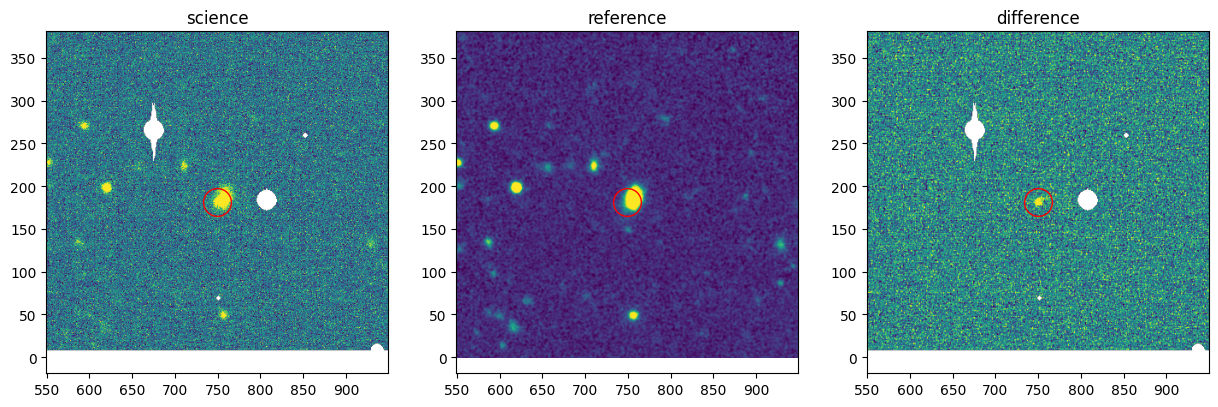

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
norm = ImageNormalize(scidata.data, PercentileInterval(98))
ax1.imshow(scidata, norm=norm)
_x, _y = astropy_world_to_pixel(ra, dec, scidata.wcs)
ax1.plot(_x, _y, marker='o', mec='r', mfc='none', ls='none', markersize=20)
ax1.set_xlim(_x-200, _x+200)
ax1.set_ylim(_y-200, _y+200)
ax1.set_title('science')

norm = ImageNormalize(refdata.data, PercentileInterval(98))
ax2.imshow(refdata, norm=norm)
ax2.plot(_x, _y, marker='o', mec='r', mfc='none', ls='none', markersize=20)
ax2.set_xlim(_x-200, _x+200)
ax2.set_ylim(_y-200, _y+200)
ax2.set_title('reference')

norm = ImageNormalize(normalized_difference.data, PercentileInterval(98))
ax3.imshow(normalized_difference, norm=norm)
ax3.plot(_x, _y, marker='o', mec='r', mfc='none', ls='none', markersize=20)
ax3.set_xlim(_x-200, _x+200)
ax3.set_ylim(_y-200, _y+200)
ax3.set_title('difference')

## Do photometry on the difference image at the provided position

In [9]:
flux_njy, flux_err, mag, mag_err, upper_limit = forced_phot(ra, dec, normalized_difference, scidata.wcs, diff_psf)
print(f"Flux: {flux_njy:.2f} ± {flux_err:.2f} nJy\nMag: {mag:.2f} ± {mag_err:.2f}\nUpper limit: {upper_limit:.2f}")

Flux: 4336.11 ± 135.13 nJy
Mag: 22.31 ± 0.03
Upper limit: 24.33


## 🔧 Use Your Own DECam Images as Templates

To use your own DECam image as the reference template for subtraction:

- Provide the following:
  - `image`: 2D array of the image data  
  - `wcs`: WCS object associated with the image  
  - `mask`: 2D array of the mask image  
  - `saturation` *(optional)*: saturation value  

### Below, we will read the DECam image from the `example_data` folder as an example.  
Make sure to set `download_DES_temp = False` and `download_DECaLS_temp = False`.

In [10]:
from astropy.wcs import WCS
import os
from astropy.io import fits

data_dir = './example_data'
image_file = 'example_decam.fits'
mask_file = 'example_decam_mask.fits'

data = fits.getdata(os.path.join(data_dir, image_file))
header = fits.getheader(os.path.join(data_dir, image_file))
mask = fits.getdata(os.path.join(data_dir, mask_file))
wcs = WCS(header)
saturation = header.get('SATURATE')

user_decam_data = load_usesr_decam(data, wcs, mask, saturation=saturation)

INFO: Query finished. [astroquery.utils.tap.core]


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

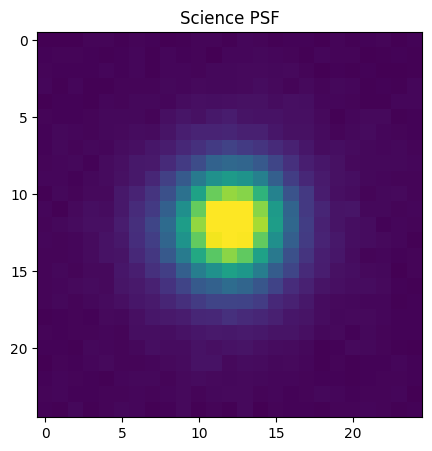

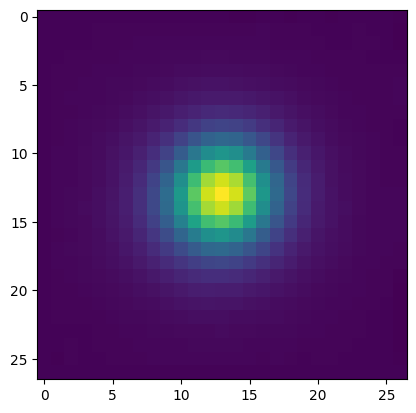

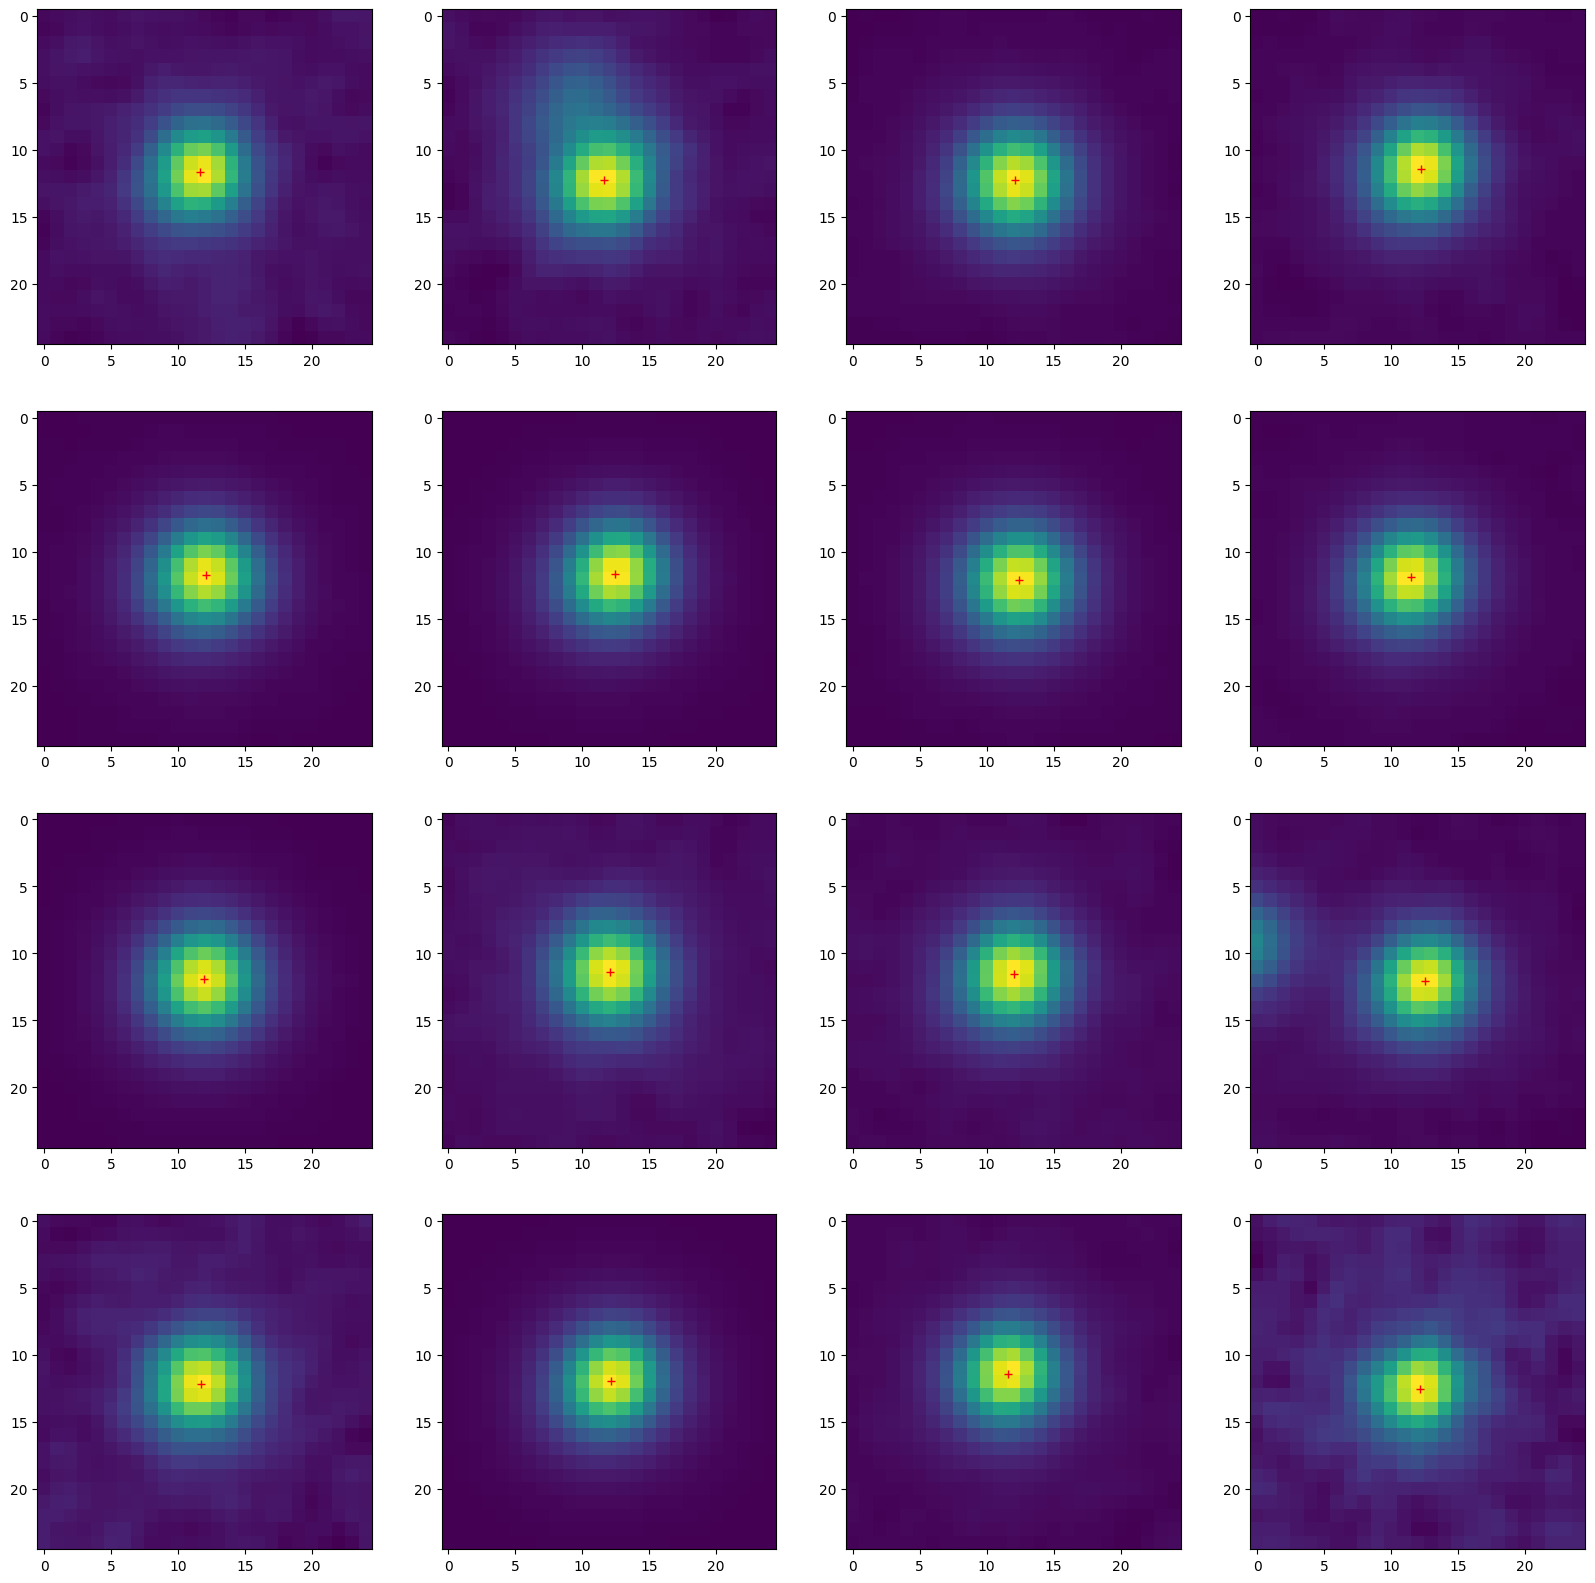

In [11]:
scidata, refdata, sci_psf, ref_psf = lsst_decam_data_load(visit_image, ra = ra, dec = dec, download_DES_temp=False, download_DECaLS_temp=False,
                                                          show=True, 
                                                          refine_wcs_sci=False, make_sci_psf=False, user_decam_data=user_decam_data,
                                                          cutout=True, cutout_size=1500, reference_catalog='gaia', workdir='./',
                                                                          save_intermediate=False)

In [12]:
normalized_difference, diff_psf = perform_image_subtraction(scidata, refdata, sci_psf, ref_psf, 
                          save_diff=False, show=False, sigma_cut=5, max_iterations=3, protect_mem=False)

Text(0.5, 1.0, 'difference')

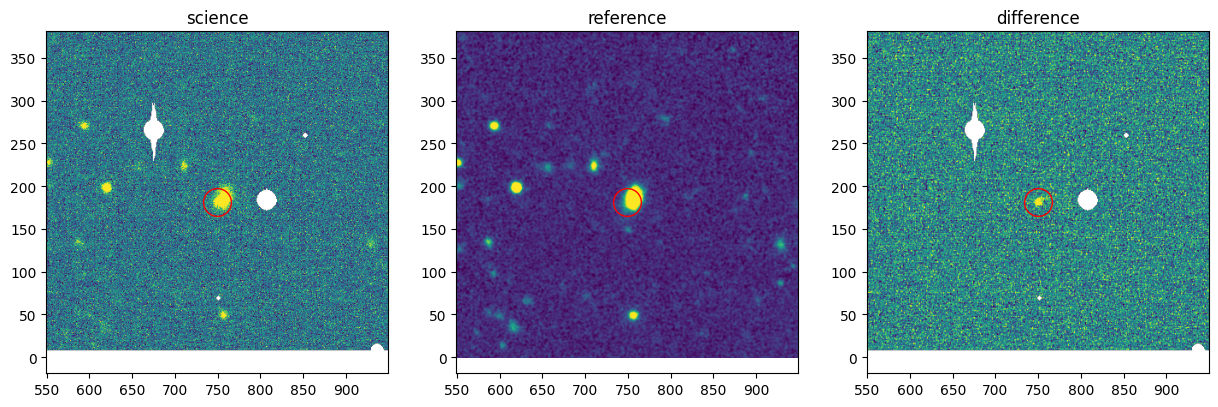

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
norm = ImageNormalize(scidata.data, PercentileInterval(98))
ax1.imshow(scidata, norm=norm)
_x, _y = astropy_world_to_pixel(ra, dec, scidata.wcs)
ax1.plot(_x, _y, marker='o', mec='r', mfc='none', ls='none', markersize=20)
ax1.set_xlim(_x-200, _x+200)
ax1.set_ylim(_y-200, _y+200)
ax1.set_title('science')

norm = ImageNormalize(refdata.data, PercentileInterval(98))
ax2.imshow(refdata, norm=norm)
ax2.plot(_x, _y, marker='o', mec='r', mfc='none', ls='none', markersize=20)
ax2.set_xlim(_x-200, _x+200)
ax2.set_ylim(_y-200, _y+200)
ax2.set_title('reference')

norm = ImageNormalize(normalized_difference.data, PercentileInterval(98))
ax3.imshow(normalized_difference, norm=norm)
ax3.plot(_x, _y, marker='o', mec='r', mfc='none', ls='none', markersize=20)
ax3.set_xlim(_x-200, _x+200)
ax3.set_ylim(_y-200, _y+200)
ax3.set_title('difference')